### Logistic regression con discesa del gradiente, regolarizzazione e funzioni base

In [1]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy.special as sp

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('ggplot')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

In [5]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml2021/dataset/"

def get_file(filename,local):
    if local:
        return filepath+filename
    else:
        urllib.request.urlretrieve (url+filename, filename)
        return filename

Funzione che effettua la normalizzazione del dataset. Modifica la distribuzione dei dati di ogni feature in modo che abbia media 0 e varianza 1, applicando la trasformazione $$x'=\frac{x-\mu}{\sigma}$$ 

In [6]:
def normalizza(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    return (X-mu)/sigma

Funzione di classificazione. Verifica per ogni elemento del dataset trasformato dalle funzioni base da che parte si trova rispetto all'iperpiano di separazione delle due classi i cui parametri sono stati determinati nel corso del training. La verifica è effettuata osservando il segno di $$\theta\cdot\phi=\sum_{i=0}^m \theta_i\phi_i$$

In [7]:
def classify(theta, phi ):
   y = np.dot(phi,theta)
   return np.where(y>0, 1, 0)

Funzione di calcolo e stampa di statistiche

In [8]:
def statistics(theta,X,t):
    # confusion matrix
    y=classify(theta,X)
    confmat = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            confmat[i,j] = np.sum(np.where(y==i,1,0)*np.where(t==j,1,0))
    print('Veri negativi: {0:d}'.format(int(confmat[0,0])))
    print('Falsi negativi: {0:d}'.format(int(confmat[0,1])))
    print('Falsi positivi: {0:d}'.format(int(confmat[1,0])))
    print('Veri positivi: {0:d}'.format(int(confmat[1,1])))
    print('Precision insieme 1: {0:5.2f}'.format(confmat[1,1]/(confmat[1,1]+confmat[1,0]),2))
    print('Recall insieme 1: {0:5.2f}'.format(confmat[1,1]/(confmat[1,1]+confmat[0,1]),2))
    print('Precision insieme 2: {0:5.2f}'.format(confmat[0,0]/(confmat[0,0]+confmat[0,1]),2))
    print('Recall insieme 2: {0:5.2f}'.format(confmat[0,0]/(confmat[0,0]+confmat[1,0]),2))
    print('Accuracy: {0:5.2f}'.format(np.trace(confmat)/n,2))
    return confmat

Funzione che calcola la funzione logistica per tutti i valori di un array, calcolando $$\sigma(x)=\frac{1}{1+e^{\theta\cdot\overline x}}$$

In [9]:
def h(theta, X):
    return sp.expit(np.dot(X, theta))

Funzione gradiente, array delle derivate del costo rispetto a $\theta_0,\ldots,\theta_d$. Risulta $$-\sum (t_i-y_i)x_i+l\theta$$ diviso per $n$

In [10]:
def gradient(theta, X, t, l):
    g = -np.dot(X.T, (t-h(theta, X)))+l*theta
    return g / len(X)

Funzione costo, definita come il negativo della log verosimiglianza sommato al termine di regolarizzazione. $$-\sum t_i\log(y_i)-\sum (1-t_i)\log(1-y_i)+\frac{l}{2}\sum \theta_k^2$$ dove $y_i=\sigma(\theta\cdot\overline x_i)$. Il risultato è diviso per $n$ per evitare valori eccessivamente grandi.

In [11]:
def cost(theta, X, t, l):
    term1 = np.dot(np.log(h(theta,X)).T,t)
    term2 = np.dot(np.log(1.0 - h(theta,X)).T,1-t)
    term3 = np.dot(theta.T,theta)*l/2
    return ((-term1 - term2 + term3) / len(X))[0][0]

Funzioni base: mappano $(x_1,x_2)$ nel vettore di tutti i monomi $x_1^ix_2^j$ tali che $i+j<=deg$

In [12]:
def mapFeature(X, deg):
    phi = np.ones(len(X)).reshape(-1,1)
    for d in range(1,deg+1):
        for i in range(0, d+1):
            term1 = X[:,0]**(d-i)
            term2 = X[:,1]**i
            term = (term1*term2).reshape(-1,1)
            phi = np.column_stack((phi, term))
    return phi

Leggiamo i dati da un file csv in un dataframe pandas. I dati hanno 3 valori: i primi due corrispondono alle features e sono assegnati alle colonne x1 e x2 del dataframe; il terzo è il valore target, assegnato alla colonna t. Vengono poi creati una matrice X delle features e un vettore target t

In [13]:
# legge i dati in dataframe pandas
data = pd.read_csv(get_file("ex2data2.txt", False), delimiter=',', header=None, names=['x1','x2','t'])

# calcola dimensione dei dati
n = len(data)

# calcola dimensionalità delle features
nfeatures = len(data.columns)-1

X = np.array(data[['x1','x2']])
t = np.array(data['t']).reshape(-1,1)

Visualizza il dataset

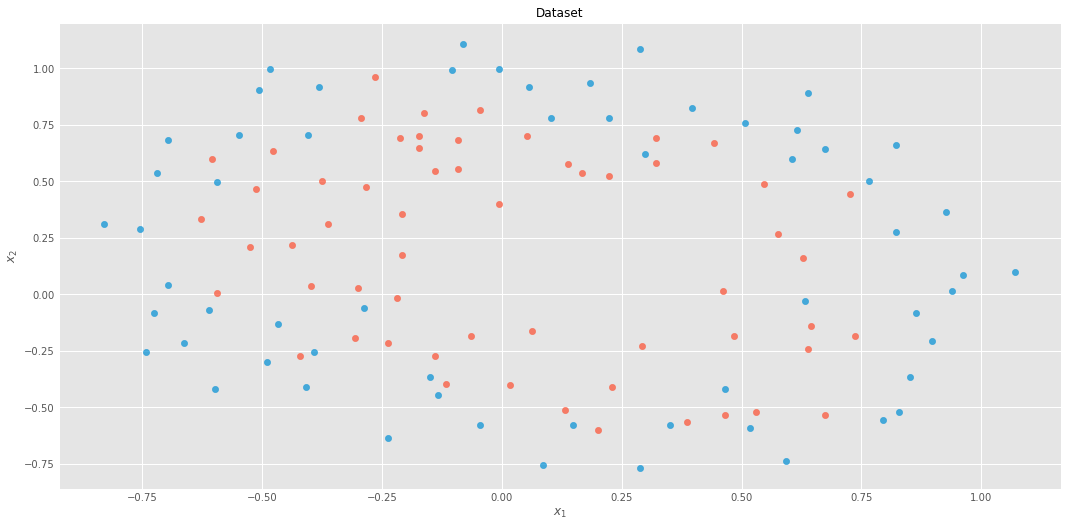

In [14]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.scatter(data[data.t==0].x1, data[data.t==0].x2, s=40, c=colors[0], alpha=.7)
ax.scatter(data[data.t==1].x1, data[data.t==1].x2, s=40, c=colors[1], alpha=.7)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Dataset', fontsize=12)
plt.show()

Calcoliamo i valori delle nuove feature

In [15]:
deg = 3
Phi = mapFeature(X, deg)

nfeatures = Phi.shape[1]-1

In [16]:
Phi.shape

(118, 10)

Fissa un valore per il parametro $\alpha$ del metodo di discesa del gradiente e per il numero di iterazione del metodo da eseguire

In [17]:
alpha = 0.1
niterations = 1000

Inizializza il vettore dei coefficienti

In [18]:
theta_init = np.zeros(nfeatures+1).reshape(-1,1)

Calcola l'array degli errori per il valore iniziale dei coefficienti

In [19]:
e = h(theta_init,Phi)-t

Applichiamo la regolarizzazione, con effetto pesato dall'iper-coefficiente $l$

In [20]:
l = 5.0

Applica la discesa del gradiente, mantenendo in $\theta$ i coefficienti attuali e memorizzando la storia dei valori dei coefficienti e dei relativi costi

In [21]:
theta_history = []
cost_history = []

# discesa del gradiente
theta = np.copy(theta_init)
for k in range(niterations):             
        theta = theta - alpha * gradient(theta,Phi,t,l)
        theta_history.append(theta)
        cost_history.append(cost(theta, Phi, t, l))

Traforma le liste theta_history e cost_history in array

In [22]:
theta_history = np.array(theta_history).reshape(-1,nfeatures+1)
cost_history = np.array(cost_history).reshape(-1,1)

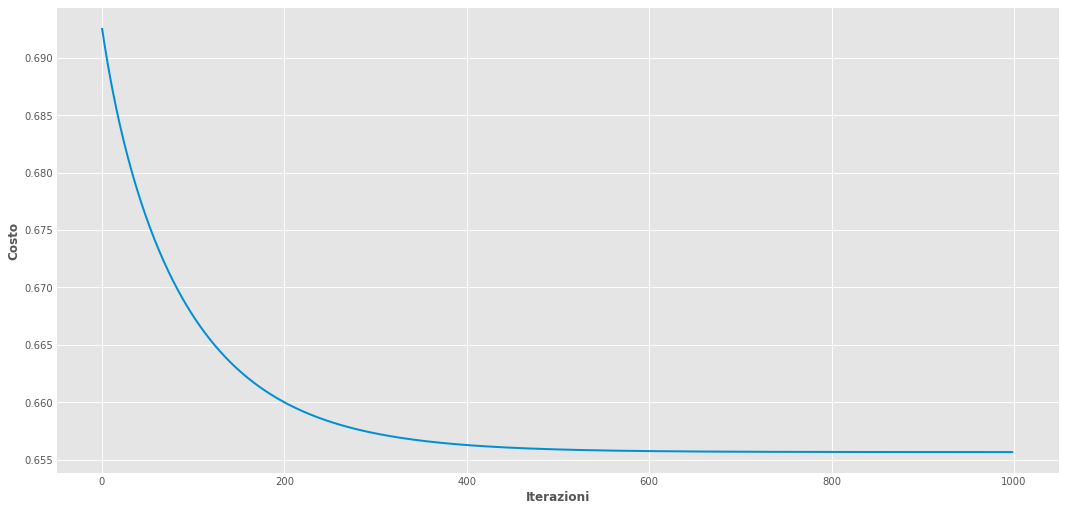

In [23]:
# visualizza andamento coefficienti e costo

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.plot(range(niterations), cost_history, c=colors[0],alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel('Costo', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


Definiamo la griglia su cui calcolare i valori della logistica

In [24]:
delta1=max(X[:,0])-min(X[:,0])
delta2=max(X[:,1])-min(X[:,1])
min1=min(X[:,0])-delta1/10
max1=max(X[:,0])+delta1/10
min2=min(X[:,1])-delta2/10
max2=max(X[:,1])+delta2/10
u = np.linspace(min1, max1, 100)
v = np.linspace(min2, max2, 100)
u, v = np.meshgrid(u, v)
x = mapFeature(np.c_[u.ravel(), v.ravel()], deg)
z = np.dot(x,theta)
p = h(theta, x)
z = z.reshape(u.shape)
p = p.reshape(u.shape)

Visualizziamo il valore della logistica e l'iperpiano di separazione

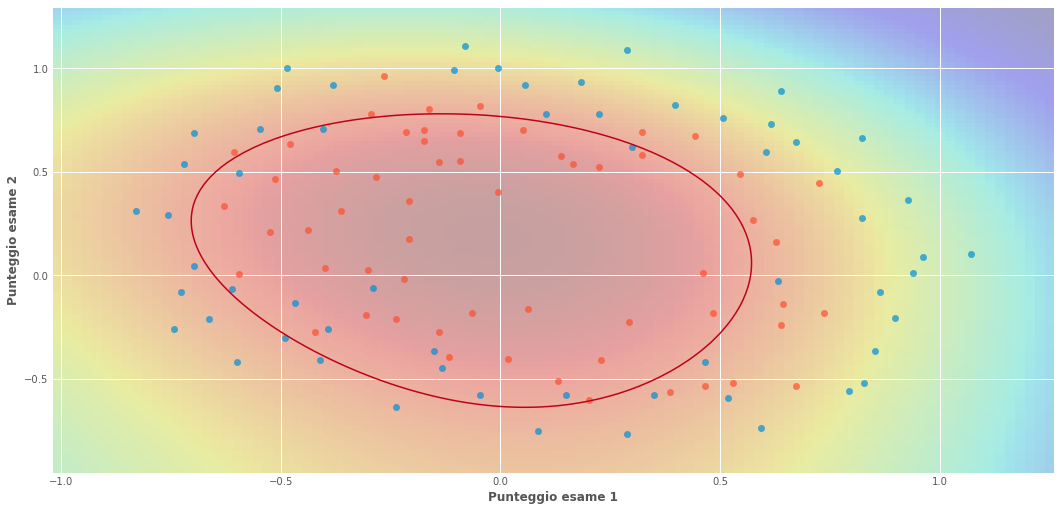

In [25]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
imshow_handle = plt.imshow(p, origin='lower', aspect='auto', extent=(min1, max1, min2, max2), alpha=.3)
ax.scatter(data[data.t==0].x1, data[data.t==0].x2, s=40, c=colors[0], alpha=.7)
ax.scatter(data[data.t==1].x1, data[data.t==1].x2, s=40, c=colors[1], alpha=.7)
plt.contour(u, v, z, [0.0], colors=[colors[7]],linewidths=[1.5])
plt.xlabel('Punteggio esame 1', fontsize=12)
plt.ylabel('Punteggio esame 2', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(min1, max1)
plt.ylim(min2, max2)
plt.show()

Calcola statistiche

In [26]:
cm=statistics(theta,Phi,t)

Veri negativi: 49
Falsi negativi: 18
Falsi positivi: 11
Veri positivi: 40
Precision insieme 1:  0.78
Recall insieme 1:  0.69
Precision insieme 2:  0.73
Recall insieme 2:  0.82
Accuracy:  0.75


Calcola la curva ROC per diversi valori della soglia

In [27]:
y = h(theta,Phi)

In [28]:
values = 1000
thresholds = np.linspace(1,0,values+1)

roc = np.zeros((values+1,3))

for i in range(values+1):
    thr = thresholds[i]
    roc[i,0] = thr
    # conta true positive, true negative, false positive e false negative per la soglia attuale
    tp = np.logical_and( y > thr, t==1 ).sum()
    tn = np.logical_and( y <=thr, t==0 ).sum()
    fp = np.logical_and( y > thr, t==0 ).sum()
    fn = np.logical_and( y <=thr, t==1 ).sum()
    # calcola false positive rate e true positive rate per la soglia attuale e li inserisce nell'array
    fpr = fp/float(fp+tn)
    roc[i,1] = fpr
    tpr = tp/float(tp+fn)
    roc[i,2] = tpr

In [29]:
auc = 0.
for i in range(values):
    auc += (roc[i+1,1]-roc[i,1]) * (roc[i+1,2]+roc[i,2])
auc *= 0.5

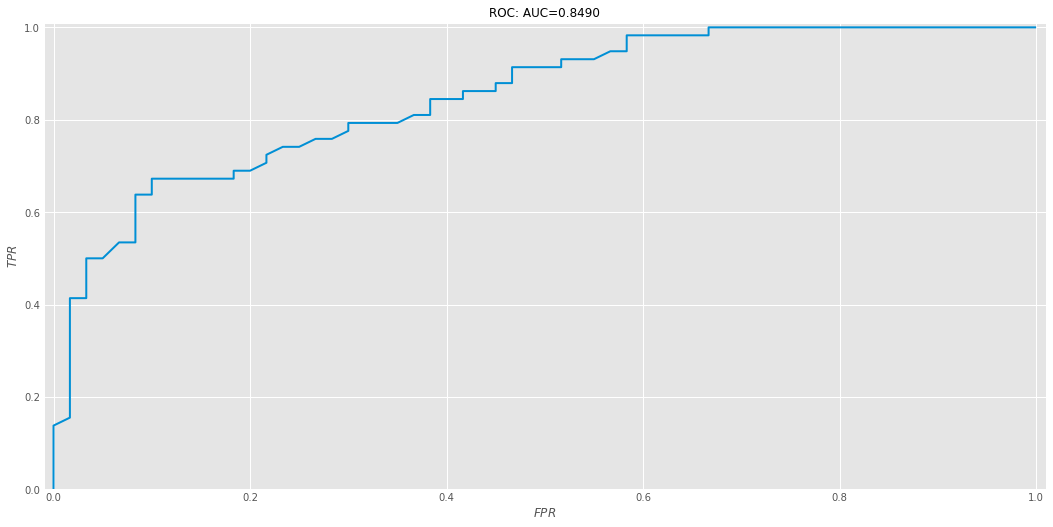

In [30]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(roc[:,1], roc[:,2], color=colors[0])
plt.xlim(-0.01,1.01)
plt.ylim(0,1.01)
plt.xlabel('$FPR$', fontsize=12)
plt.ylabel('$TPR$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('ROC: AUC={0:5.4f}'.format(auc), fontsize=12)
plt.show()